In [1]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
INPUT_DIRECTORY = "/Users/dinge/Public/roofline/"

In [3]:
os.chdir(INPUT_DIRECTORY)

In [4]:
def plot_bandwidth(summary):
    plt.plot(summary.x, summary.band)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel("Total Bandwidth (GB/s)")
    plt.xlabel("Working set size (bytes)")
    plt.show() 
    
def plot_gflops(summary):
    plt.plot(summaries[0].x, summaries[0].gflops)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel("GFLOPs/sec")
    plt.xlabel("Working set size (bytes)")
    plt.show() 

In [5]:
def smooth(y):
    ys = y[:]

    d = 0

    for i in range(len(ys)):
        num = min(len(ys),i+d+1) - max(0,i-d)
        total = sum(ys[max(0,i-d):min(len(ys),i+d+1)])
        ys[i] = total/float(num)

    return ys

def calculate_bandwidths(summary):
    max_band = max(summary.band)
    num_buckets = 10000
    threshold = 1.05
    buckets = [0] * num_buckets
    bucket_values = [0] * num_buckets
    band = summary.band[summary.band.index(max_band):]
    band = smooth(band)
    for i in range(0, num_buckets):
        value = (max_band / num_buckets) * i
        bucket_min = value/threshold
        bucket_max = value * threshold
        for b in band:
            if b > bucket_min and b < bucket_max:
                buckets[i] += 1
                bucket_values[i] = b
                
    band_list = [[max_band*1000,1000]]
    maxc = -1
    maxi = -1
    for i in range(num_buckets-3,1,-1):
        if buckets[i] > 6:
            if buckets[i] > maxc:
                maxc = buckets[i]
                maxi = i
        else:
            threshold = 1.25
            if maxc > 1:
                value = float(bucket_values[maxi])/max(1,buckets[maxi])
                if threshold*value < float(band_list[-1][0])/band_list[-1][1]:
                    band_list.append([bucket_values[maxi],buckets[maxi]])
                else:
                    band_list[-1][0] += bucket_values[maxi]
                    band_list[-1][1] += buckets[maxi]
            maxc = -1
            maxi = -1
            
    print(band_list)
    summary.max_dram = band_list[-1][0]
    try:
        summary.max_l1 = band_list[-2][0]
        summary.max_l2 = band_list[-3][0]
    except:
        pass

def calculate_weight(summary):
    weight = 0
    for i in range(0,len(summary.x)-1):
        x1 = math.log(summary.x[i])
        y1 = summary.band[i]

        x2 = math.log(summary.x[i+1])
        y2 = summary.band[i+1]

        weight += (y1+y2)/2.0 * (x2-x1)
    summary.weight = weight

In [24]:
# Remove 

class RAW_INDEX:
    working_set_size = 0
    num_trials = 1
    time = 2
    bytes = 3
    flops=4

class TestSummary(object):
    def __init__(self):
        self.max_gflops = -math.inf
        self.weight = None
        self.max_l1 = None
        self.max_l2 = None
        self.max_dram = None
        self.flops = None
        self.threads = None
        self.x = []
        self.band = []
        self.gflops = []
        
def get_test_summaries():  
    summaries = []
    # Parse raw test data into list of test summaries
    for filename in os.listdir():
        if not filename.endswith(".gables"):
            continue;
        summary = TestSummary()
        with open(os.path.join(INPUT_DIRECTORY, filename), 'r') as file:
            prev_values = None
            is_metadata = False
            for line in file.readlines():
                if line.strip() == "":
                    continue
                if is_metadata:
                    # Parse metadata
                    values = line.strip().split()
                    if values[0] == "FLOPS":
                        summary.flops = float(values[1])
                        continue
                    else:
                        summary.threads = float(values[1])
                        break
                if line.strip() == "META_DATA":
                    # We have reached meta data
                    is_metadata = True
                    continue
                # This is a normal line of data
                values = [float(x) for x in line.strip().split()]
                if not prev_values or prev_values[RAW_INDEX.num_trials] < values[RAW_INDEX.num_trials] or values == []:
                    prev_values = values
                    continue
                else:
                    # We want to consider this value
                    if prev_values[RAW_INDEX.time] == 0:
                        prev_values[RAW_INDEX.time] = 1 ** (-10)
                    summary.max_gflops = max(summary.max_gflops, prev_values[RAW_INDEX.flops]/prev_values[RAW_INDEX.time])
                    summary.x.append(prev_values[RAW_INDEX.working_set_size])
                    summary.gflops.append((prev_values[RAW_INDEX.flops]/prev_values[RAW_INDEX.time])/1000)
                    summary.band.append((prev_values[RAW_INDEX.bytes]/prev_values[RAW_INDEX.time])/1000)
                    prev_values = values
        # Calculate max l1, l2 and dram bandwidth
        calculate_bandwidths(summary)
        # Calculate weight
        calculate_weight(summary)
        summaries.append(summary)
    return summaries

In [25]:
def plot_roofline(summaries):
    max_index = 0
    max_weight = -math.inf
    
    max_gflops = -math.inf
    
    for i, summary in enumerate(summaries):
        max_gflops = max(max_gflops, summary.max_gflops)
        if summary.weight > max_weight:
            max_index = i
            max_weight = summary.weight
    summary = summaries[max_index]
    
    x = np.logspace(-1, 5, 1000)
    plt.yscale("log")
    plt.xscale("log")
    
    if summary.max_dram:
        ys = np.minimum(summary.max_dram * x, np.repeat(summary.max_gflops, len(x)))
        plt.plot(x, ys, label="DRAM {} GB/s".format(summary.max_dram))
        
    if summary.max_l1:
        ys = np.minimum(summary.max_l1 * x, np.repeat(summary.max_gflops, len(x)))
        plt.plot(x, ys, label="L1 {} GB/s".format(summary.max_l1))
        
    if summary.max_l2:
        ys = np.minimum(summary.max_l2 * x, np.repeat(summary.max_gflops, len(x)))
        plt.plot(x, ys, label="L2 {} GB/s".format(summary.max_l2))
        
    plt.legend()
    plt.xlabel("Flops/byte")
    plt.ylabel("MFlops/second")
    mpl.rcParams['figure.figsize'] = (10,5)
    plt.show()
    

In [26]:
summary = get_test_summaries()[0]

[[10133.20508877394, 1000], [16.04930018062003, 107]]


In [27]:
print(summary.max_gflops)
print(summary.max_l1)
print(summary.max_l2)
print(summary.max_dram)

print(summary.max_gflops / summary.max_l1)
print(summary.max_gflops / summary.max_l2)
print(summary.max_gflops / summary.max_dram)

633.3253180483713
10133.20508877394
None
16.04930018062003
0.0625


TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

[[10133.20508877394, 1000], [16.04930018062003, 107]]


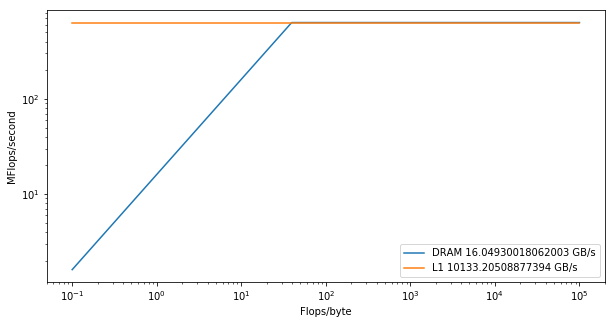

In [28]:
plot_roofline(get_test_summaries())

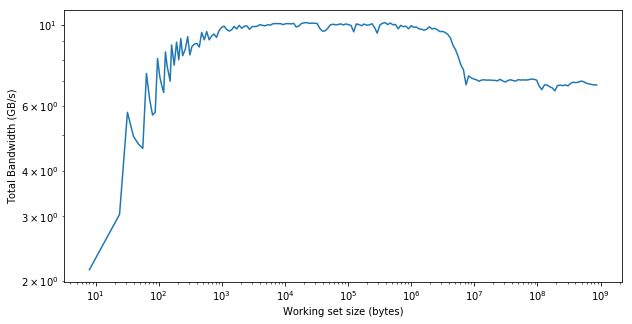

In [29]:
plot_bandwidth(summary)

In [13]:
print(summary.max_gflops)

1584.794701986755


In [22]:
os.listdir()

['threads-8_flops-4_neon-false.gables',
 'threads-8_flops-1_neon-false.gables',
 'threads-8_flops-2_neon-false.gables']

In [23]:
os.listdir()


['obj',
 'inc',
 'run-arm.sh',
 'Android.mk',
 'build-x86.sh',
 'Application.mk',
 'Makefile',
 'ndk_sweep.py',
 'build-arm.sh',
 'libs',
 'new-gables.ipynb',
 '.ipynb_checkpoints',
 '.git',
 'out-1.gables',
 'src']